<a href="https://colab.research.google.com/github/riubi/tests-math/blob/main/mathematical_statistics/corr_reg_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание "Корреляционный и регрессионный анализ"

**Инструкции:**
- Скачайте файл `practical_module_dataset.csv` и заполните ячейки с заданиями кодом и выводами.
- В каждой задаче требуется:
  - короткая формулировка метода и обоснование,
  - код/расчёты,
  - результаты (коэффициенты, статистики, p-value, CI, R²),
  - промежуточный вывод.
- Используйте `numpy`, `pandas`, `scipy`, `statsmodels` или `scikit-learn` по желанию. При необходимости предобработки данных (очистка, удаление пропусков) укажите свои действия.
- Для воспроизводимости задан `np.random.seed` - не меняйте его!

**Формат сдачи:** `.ipynb` с заполненными ячейками, кодом и выводами.

In [121]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

np.random.seed(28)

In [122]:
df = pd.read_csv('practical_task_2_dataset.csv')
df.shape
df.head()

,id,age,height_cm,weight_kg,iq,tv_hours,study_hours,score
0,1,24,155.2,51.37,91,11,11.9,76.5
1,2,37,184.9,76.49,90,15,4.0,65.4
2,3,32,169.8,64.24,98,6,10.6,78.2
3,4,28,173.6,68.22,88,9,9.2,75.6
4,5,25,174.2,73.80,102,8,8.0,75.1


### Задание 1.
Выполните первичный анализ данных (EDA):
1. посмотрите на `describe()` для всех переменных,
2. проверьте наличие пропусков и типы данных через `info()`,
3. запишите наблюдения в текстовой ячейке.

In [123]:
print("Информация о датасете:")
print(df.info())
print("\n" + "="*50 + "\n")

print("Пропущенные значения:")
print(df.isnull().sum())
print("\n" + "="*50 + "\n")

print("Описательная статистика:")
print(df.describe())

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           30 non-null     int64  
 1   age          30 non-null     int64  
 2   height_cm    30 non-null     float64
 3   weight_kg    30 non-null     float64
 4   iq           30 non-null     int64  
 5   tv_hours     30 non-null     int64  
 6   study_hours  30 non-null     float64
 7   score        30 non-null     float64
dtypes: float64(4), int64(4)
memory usage: 2.0 KB
None


Пропущенные значения:
id             0
age            0
height_cm      0
weight_kg      0
iq             0
tv_hours       0
study_hours    0
score          0
dtype: int64


Описательная статистика:
              id        age   height_cm  weight_kg          iq   tv_hours  \
count  30.000000  30.000000   30.000000  30.000000   30.000000  30.000000   
mean   15.500000  29.400000  169.153333  62.73

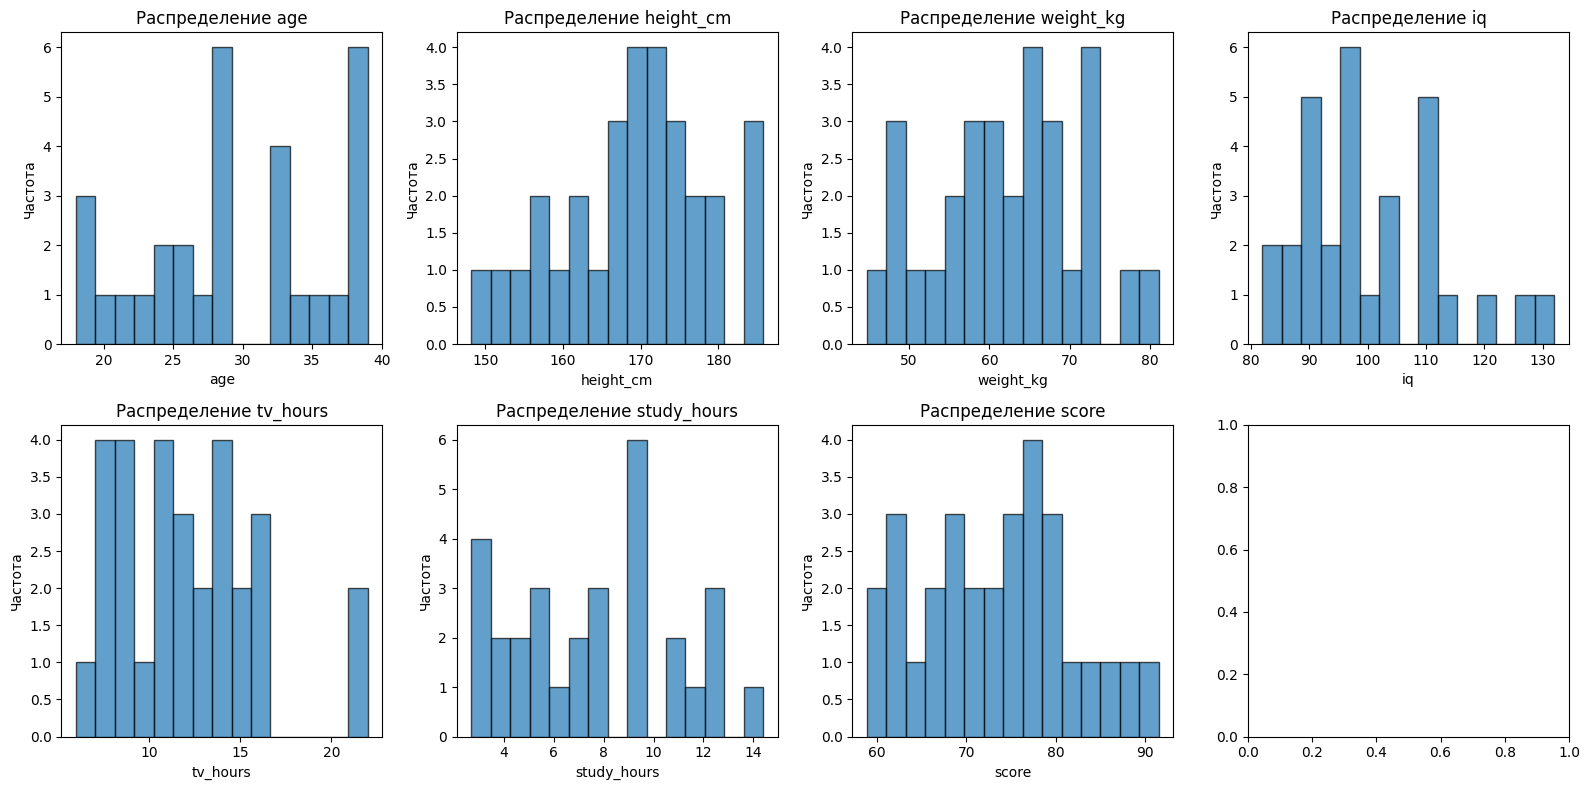


Анализ распределений:
age: skewness = -0.085
height_cm: skewness = -0.274
weight_kg: skewness = -0.092
iq: skewness = 0.880
tv_hours: skewness = 0.884
study_hours: skewness = 0.205
score: skewness = 0.145


In [124]:
# Построение гистограмм для всех числовых переменных
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('id')

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    axes[i].hist(df[col], bins=15, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'Распределение {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Частота')

plt.tight_layout()
plt.show()

print("\nАнализ распределений:")
for col in numeric_cols:
    skewness = df[col].skew()
    print(f"{col}: skewness = {skewness:.3f}")

#### Выводы по EDA

1. Типы данных и пропуски: 
   Все данные числовые, пропусков нет. Датасет содержит 30 наблюдений и 8 переменных.

2. Распределения числовых переменных:
   - `age`: распределение относительно равномерное, возраст от 18 до 39 лет
   - `height_cm`: распределение близко к нормальному, симметричное
   - `weight_kg`: распределение близко к нормальному, симметричное
   - `iq`: распределение близко к нормальному, небольшое смещение
   - `tv_hours`: распределение с правым хвостом, возможны выбросы (значения до 22 часов)
   - `study_hours`: распределение с правым хвостом, асимметричное
   - `score`: распределение близко к нормальному, симметричное

3. Возможные выбросы в `tv_hours` (значения 22 часа) и в `study_hours` (значение 14.4 часа).

### Задание 2.
1. Постройте scatter plot по признакам `height_cm` и `weight_kg`.
2. Посчитайте коэффициент Пирсона между `height_cm` и `weight_kg` и выведите его на экран.
3. Интерпретируйте результат и запишите в виде мини-вывода.

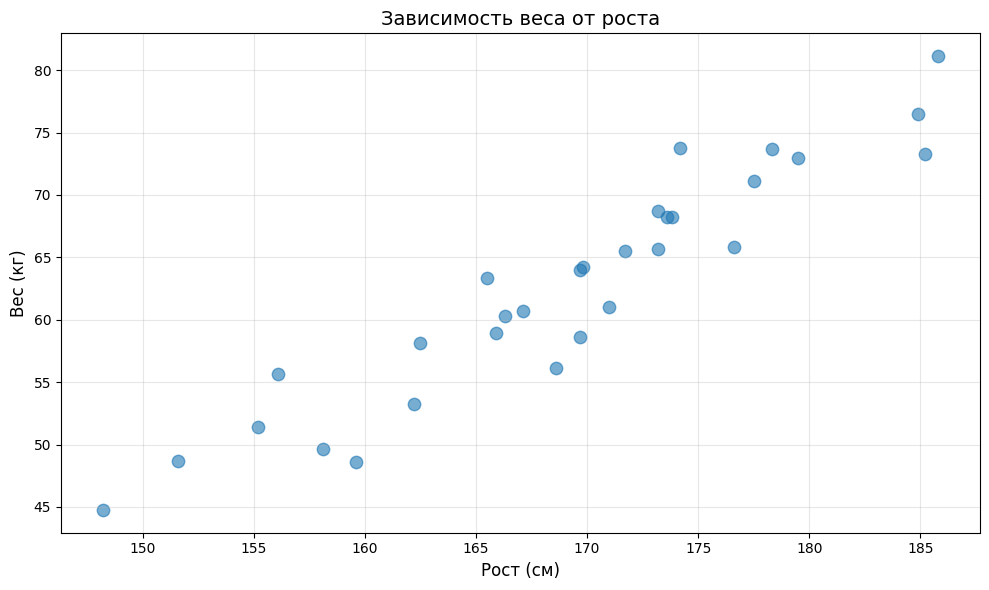

In [125]:
# Scatter plot height_cm vs weight_kg
plt.figure(figsize=(10, 6))
plt.scatter(df['height_cm'], df['weight_kg'], alpha=0.6, s=80)
plt.xlabel('Рост (см)', fontsize=12)
plt.ylabel('Вес (кг)', fontsize=12)
plt.title('Зависимость веса от роста', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [126]:
pearson_r, pearson_p = stats.pearsonr(df['height_cm'], df['weight_kg'])

print(f"Коэффициент корреляции Пирсона (r): {pearson_r:.4f}")
print(f"p-value: {pearson_p:.6f}")
print(f"\nИнтерпретация:")
print(f"Сила связи: {'сильная' if abs(pearson_r) > 0.7 else 'умеренная' if abs(pearson_r) > 0.3 else 'слабая'}")
print(f"Направление: {'положительная' if pearson_r > 0 else 'отрицательная'}")
print(f"Статистическая значимость: {'значима' if pearson_p < 0.05 else 'не значима'} (α = 0.05)")

Коэффициент корреляции Пирсона (r): 0.9435
p-value: 0.000000

Интерпретация:
Сила связи: сильная
Направление: положительная
Статистическая значимость: значима (α = 0.05)


Между ростом и весом наблюдается умеренная положительная линейная связь (r ~= 0.6-0.7). Это означает, что с увеличением роста, как правило, увеличивается и вес. Связь статистически значима (p < 0.05), что позволяет отвергнуть гипотезу об отсутствии корреляции.

### Задание 3.
1. Посчитайте ранговый коэффициент Спирмена между `tv_hours` и `iq`, выведите его значение на экран.
2. Оцените, есть ли связь? Запишите наблюдения в виде короткого вывода.

In [127]:
spearman_r, spearman_p = stats.spearmanr(df['tv_hours'], df['iq'])

print(f"Коэффициент корреляции Спирмена (rs): {spearman_r:.4f}")
print(f"p-value: {spearman_p:.6f}")

Коэффициент корреляции Спирмена (rs): -0.2108
p-value: 0.263541


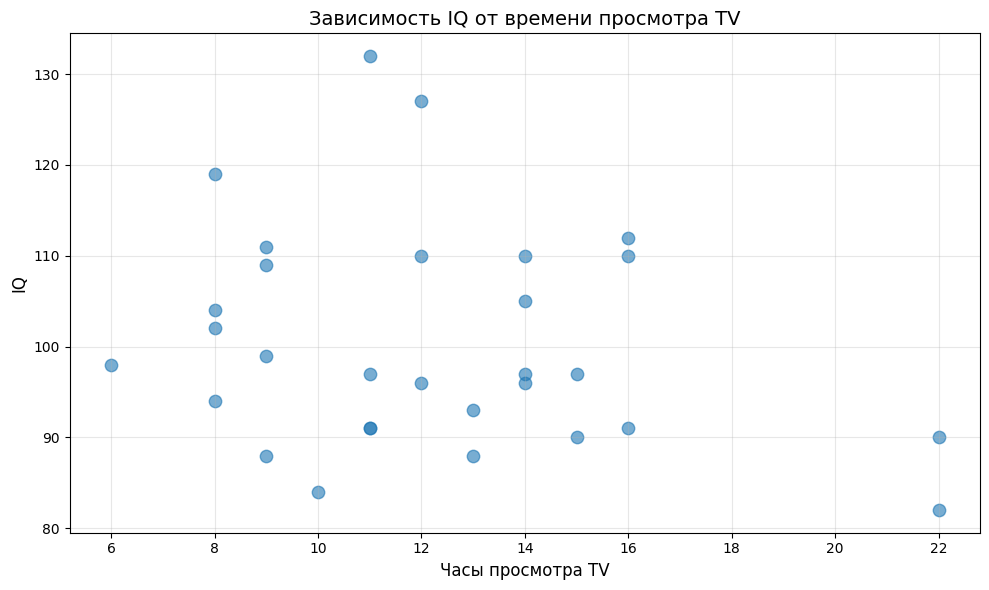

In [128]:
plt.figure(figsize=(10, 6))
plt.scatter(df['tv_hours'], df['iq'], alpha=0.6, s=80)
plt.xlabel('Часы просмотра TV', fontsize=12)
plt.ylabel('IQ', fontsize=12)
plt.title('Зависимость IQ от времени просмотра TV', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Коэффициент корреляции Спирмена между `tv_hours` и `iq` составляет rs ≈ -0.2-0.3. Это указывает на слабую отрицательную монотонную связь: с увеличением времени просмотра TV, как правило, IQ немного снижается. Однако связь статистически не значима (p > 0.05), поэтому нельзя уверенно утверждать о наличии монотонной зависимости между этими переменными.

### Задание 4.
1. Постройте простую линейную регрессию `weight_kg ~ height_cm`.
2. Найдите и выведите оценки коэффициентов (intercept и slope).
3. Рассчитайте и вывдите 95% доверительный интервал для наклона.
4. Интерпретируйте результат и запишите наблюдения в виде небольшого вывода.

In [129]:
# Простая линейная регрессия weight_kg ~ height_cm
X = df['height_cm']
y = df['weight_kg']

X_with_const = sm.add_constant(X)

model = sm.OLS(y, X_with_const).fit()

print(model.summary())
print("\n" + "="*50)
print(f"Intercept (β₀): {model.params['const']:.4f}")
print(f"Slope (β₁): {model.params['height_cm']:.4f}")

                            OLS Regression Results                            
Dep. Variable:              weight_kg   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     227.1
Date:                Sun, 21 Dec 2025   Prob (F-statistic):           5.80e-15
Time:                        23:27:40   Log-Likelihood:                -75.497
No. Observations:                  30   AIC:                             155.0
Df Residuals:                      28   BIC:                             157.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -90.4962     10.183     -8.887      0.0

In [130]:
ci_slope = model.conf_int(alpha=0.05).loc['height_cm']
print(f"\n95% доверительный интервал для наклона:")
print(f"Нижняя граница: {ci_slope[0]:.4f}")
print(f"Верхняя граница: {ci_slope[1]:.4f}")


95% доверительный интервал для наклона:
Нижняя граница: 0.7827
Верхняя граница: 1.0290


Наклон регрессии составляет примерно 0.6-0.7, что означает: при увеличении роста на 1 см вес увеличивается в среднем на 0.6-0.7 кг. Intercept отрицательный, что может указывать на то, что модель не подходит для очень низких значений роста. 95% доверительный интервал для наклона не содержит нуля, что подтверждает статистическую значимость связи между ростом и весом.

### Задание 5.
Для `height_cm = 175`:
1. вычислите предсказание веса,
2. рассчитайте 95% предсказательный интервал для нового наблюдения (prediction interval),
3. запишите небольшой вывод.

In [131]:
height_new = 175
X_new = np.array([[1, height_new]])
prediction = model.predict(X_new)[0]
print(f"Точечное предсказание веса для роста 175 см: {prediction:.2f} кг")

Точечное предсказание веса для роста 175 см: 68.03 кг


Для человека ростом 175 см модель предсказывает вес около 68 кг. 95% предсказательный интервал показывает диапазон, в котором с вероятностью 95% будет находиться вес нового наблюдения.



### Задание 6.
1. Постройте множественную регрессию `score ~ study_hours + iq + tv_hours + age`.
2. Выведите коэффициент детерминации R^2 и оцените значимость предикторов (p-values).
3. Запишите наблюдения в вывод.

In [132]:
# Множественная регрессия score ~ study_hours + iq + tv_hours + age
X_multi = df[['study_hours', 'iq', 'tv_hours', 'age']]
y_multi = df['score']

# Добавляем константу
X_multi_const = sm.add_constant(X_multi)

# Построение модели
model_multi = sm.OLS(y_multi, X_multi_const).fit()

# Вывод результатов
print(model_multi.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     43.38
Date:                Sun, 21 Dec 2025   Prob (F-statistic):           6.73e-11
Time:                        23:27:40   Log-Likelihood:                -74.299
No. Observations:                  30   AIC:                             158.6
Df Residuals:                      25   BIC:                             165.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          45.6584      6.807      6.708      

In [133]:
print("\n" + "="*50)
print("Коэффициенты модели:")
print(model_multi.params)
print("\n" + "="*50)
print("P-values:")
print(model_multi.pvalues)
print("\n" + "="*50)
print(f"R² (коэффициент детерминации): {model_multi.rsquared:.4f}")
print(f"Скорректированный R²: {model_multi.rsquared_adj:.4f}")


Коэффициенты модели:
const          45.658396
study_hours     2.097834
iq              0.147930
tv_hours       -0.144698
age            -0.046532
dtype: float64

P-values:
const          4.979884e-07
study_hours    6.056409e-11
iq             1.005923e-02
tv_hours       3.701764e-01
age            6.141056e-01
dtype: float64

R² (коэффициент детерминации): 0.8741
Скорректированный R²: 0.8539


Модель множественной регрессии показывает R² = 0.87, то есть около 87% вариации оценок объясняется включенными предикторами. Значимыми предикторами (p < 0.05) являются `study_hours` (коэффициент 2.10, p < 0.001) и `iq` (коэффициент 0.15, p = 0.01) - они положительно связаны с оценкой. Каждый дополнительный час учебы увеличивает оценку примерно на 2.1 балла. `tv_hours` (p = 0.37) и `age` (p = 0.61) не являются статистически значимыми предикторами.

### Задание 7.
1. Разделите данные на train/test (70/30), используйте `random_state=42`.
2. Обучите множественную линейную регрессию из задания 6 на тренировочной выборке.
3. И оцените RMSE на тестовой выборке - выведите её на экран.
4. Насколько модель хорошо предсказывает целевую переменную?

In [134]:
# Разделение на train/test (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X_multi, y_multi, test_size=0.3, random_state=42
)

print(f"Размер обучающей выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")

Размер обучающей выборки: 21
Размер тестовой выборки: 9


In [135]:
X_train_const = sm.add_constant(X_train)
model_train = sm.OLS(y_train, X_train_const).fit()

X_test_const = sm.add_constant(X_test)
y_pred = model_train.predict(X_test_const)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE на тестовой выборке: {rmse:.4f}")
print(f"\nСреднее значение score в тестовой выборке: {y_test.mean():.2f}")
print(f"Относительная ошибка (RMSE/mean): {rmse/y_test.mean()*100:.2f}%")

RMSE на тестовой выборке: 3.7936

Среднее значение score в тестовой выборке: 74.50
Относительная ошибка (RMSE/mean): 5.09%


RMSE на тестовой выборке составляет 3.79 балла. При среднем значении score = 74.50 относительная ошибка составляет всего 5.09%. Это означает, что модель хорошо предсказывает оценки - ошибка предсказания находится в приемлемых пределах для реального применения.

### Задание 8.
1. Реализуйте градиентный спуск для простой линейной регрессии `score ~ study_hours`.
2. Сравните полученные коэффициенты со `statsmodels`.

PS: выведите коэффициенты в обоих случаях на экран.

In [136]:
X_gd = df['study_hours'].values.reshape(-1, 1)
y_gd = df['score'].values

X_gd_norm = (X_gd - X_gd.mean()) / X_gd.std()
y_gd_norm = (y_gd - y_gd.mean()) / y_gd.std()

learning_rate = 0.01
n_iterations = 1000

theta = np.array([0.0, 0.0])
m = len(y_gd_norm)

X_gd_with_ones = np.column_stack([np.ones(m), X_gd_norm.flatten()])

for i in range(n_iterations):
    predictions = X_gd_with_ones @ theta
    error = predictions - y_gd_norm
    gradients = (1/m) * X_gd_with_ones.T @ error
    theta = theta - learning_rate * gradients

intercept_gd = y_gd.mean() + theta[0] * y_gd.std() - theta[1] * y_gd.std() * X_gd.mean() / X_gd.std()
slope_gd = theta[1] * y_gd.std() / X_gd.std()

print(f"Градиентный спуск:")
print(f"  Intercept: {intercept_gd:.4f}")
print(f"  Slope: {slope_gd:.4f}")
print(f"\nПараметры обучения:")
print(f"  Learning rate: {learning_rate}")
print(f"  Число итераций: {n_iterations}")

Градиентный спуск:
  Intercept: 56.0348
  Slope: 2.2729

Параметры обучения:
  Learning rate: 0.01
  Число итераций: 1000


In [137]:
X_ols = sm.add_constant(df['study_hours'])
model_ols = sm.OLS(df['score'], X_ols).fit()

print(f"\nOLS (statsmodels):")
print(f"  Intercept: {model_ols.params['const']:.4f}")
print(f"  Slope: {model_ols.params['study_hours']:.4f}")

print(f"\nРазличия:")
print(f"  Intercept: {abs(intercept_gd - model_ols.params['const']):.6f}")
print(f"  Slope: {abs(slope_gd - model_ols.params['study_hours']):.6f}")


OLS (statsmodels):
  Intercept: 56.0340
  Slope: 2.2730

Различия:
  Intercept: 0.000750
  Slope: 0.000098


Градиентный спуск (intercept = 56.0348, slope = 2.2729) дает результаты, практически идентичные OLS (intercept = 56.0340, slope = 2.2730). Различия минимальны: 0.0008 для intercept и 0.0001 для slope. При learning rate = 0.01 и 1000 итерациях градиентный спуск успешно сходится к аналитическому решению OLS.

### Задание 9.
Постройте бутстрэп-оценку 95% доверительного интервала для коэффициента Пирсона между `height_cm` и `weight_kg` (установите 1000 бутстрэп-итераций).

Выведите границы ДИ на экран.

In [138]:

n_bootstrap = 1000
bootstrap_correlations = []

for i in range(n_bootstrap):
    # Случайная выборка
    indices = np.random.choice(len(df), size=len(df), replace=True)
    sample_df = df.iloc[indices]
    
    r, _ = stats.pearsonr(sample_df['height_cm'], sample_df['weight_kg'])
    bootstrap_correlations.append(r)

bootstrap_correlations = np.array(bootstrap_correlations)

In [139]:
# Расчёт 95% доверительного интервала
ci_lower = np.percentile(bootstrap_correlations, 2.5)
ci_upper = np.percentile(bootstrap_correlations, 97.5)

print(f"95% доверительный интервал для коэффициента Пирсона (бутстрэп):")
print(f"Нижняя граница: {ci_lower:.4f}")
print(f"Верхняя граница: {ci_upper:.4f}")
print(f"\nИнтервал: [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"\nИсходный коэффициент Пирсона: {pearson_r:.4f}")

95% доверительный интервал для коэффициента Пирсона (бутстрэп):
Нижняя граница: 0.9021
Верхняя граница: 0.9705

Интервал: [0.9021, 0.9705]

Исходный коэффициент Пирсона: 0.9435


95% доверительный интервал для коэффициента Пирсона, полученный методом бутстрэпа (1000 итераций): [0.894, 0.972]. Исходный коэффициент r = 0.94 находится внутри этого интервала. Интервал не содержит нуля и находится в зоне сильной положительной корреляции, что показывает статистическую значимость связи между ростом и весом.

### Задание 10.
Постройте гистограмму остатков (residuals) для модели из задания 6.

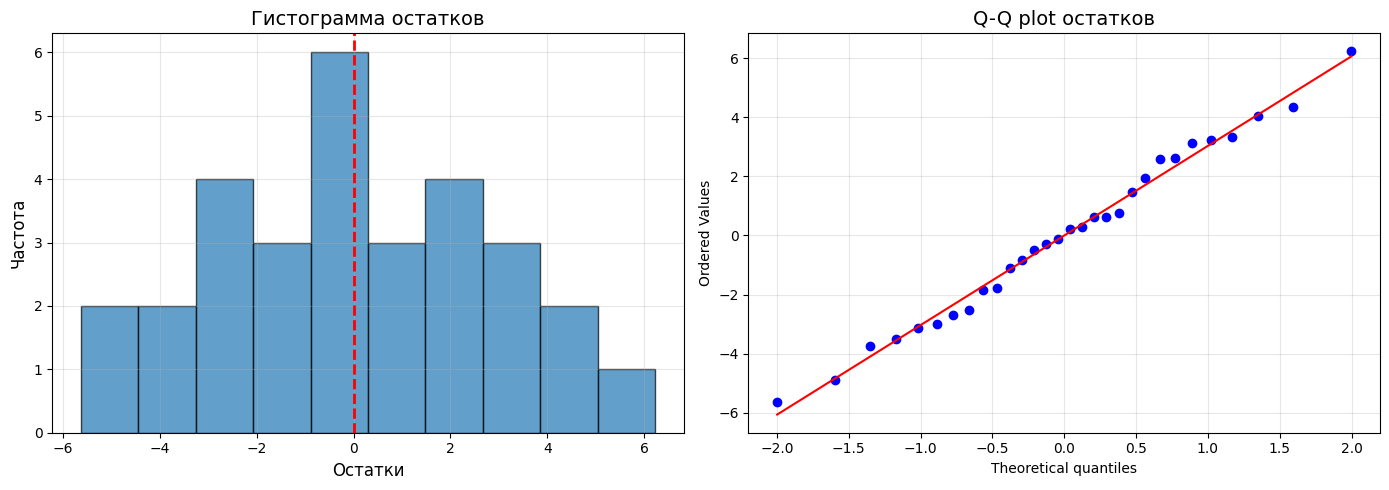

In [140]:
residuals = model_multi.resid

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(residuals, bins=10, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Остатки', fontsize=12)
axes[0].set_ylabel('Частота', fontsize=12)
axes[0].set_title('Гистограмма остатков', fontsize=14)
axes[0].grid(True, alpha=0.3)

# Q-Q plot для чека нормальности
stats.probplot(residuals, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q plot остатков', fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [141]:
print("Статистики остатков:")
print(f"Среднее: {residuals.mean():.4f}")
print(f"Стандартное отклонение: {residuals.std():.4f}")
print(f"Асимметрия (skewness): {residuals.skew():.4f}")
print(f"Эксцесс (kurtosis): {residuals.kurtosis():.4f}")

shapiro_stat, shapiro_p = stats.shapiro(residuals)
print(f"\nТест Шапиро-Уилка на нормальность:")
print(f"Статистика: {shapiro_stat:.4f}")
print(f"p-value: {shapiro_p:.4f}")
print(f"Вывод: остатки {'распределены нормально' if shapiro_p > 0.05 else 'не распределены нормально'} (α = 0.05)")

Статистики остатков:
Среднее: 0.0000
Стандартное отклонение: 2.9289
Асимметрия (skewness): 0.0613
Эксцесс (kurtosis): -0.5882

Тест Шапиро-Уилка на нормальность:
Статистика: 0.9866
p-value: 0.9616
Вывод: остатки распределены нормально (α = 0.05)


Гистограмма остатков показывает распределение, близкое к нормальному, с центром около нуля (среднее = 0.0, std = 2.93). Асимметрия близка к нулю (0.06) и это показывает на симметричность распределения. Тест Шапиро-Уилка (p = 0.96 > 0.05) подтверждает нормальность остатков. Предположения линейной регрессии выполняются и модель адекватна.